In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import time
from urllib.request import urlretrieve
import os



nsl_train_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTrain+.txt"
nsl_test_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTest+.txt"

nsl_train_file = "KDDTrain+.txt"
nsl_test_file = "KDDTest+.txt"



if not os.path.exists(nsl_train_file):
    print("Downloading NSL-KDD training dataset...")
    urlretrieve(nsl_train_url, nsl_train_file)

if not os.path.exists(nsl_test_file):
    print("Downloading NSL-KDD testing dataset...")
    urlretrieve(nsl_test_url, nsl_test_file)


# Define column names
# KDD dataset has 41 features + 1 label column
kdd_columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
]

# NSL-KDD includes an additional difficulty column
nsl_columns = kdd_columns + ["difficulty"]

# File paths - update these to your actual file paths
train_file = "KDDTrain+.txt"
test_file = "KDDTest+.txt"

# Load the data
print("Loading data...")
train_full = pd.read_csv(train_file, names=nsl_columns)
test = pd.read_csv(test_file, names=nsl_columns)

# Data preprocessing function
def preprocess_data(df):
    # Make a copy to avoid modifying the original dataframe
    df_processed = df.copy()

    # Initialize label encoder
    label_encoders = {}

    # Convert categorical features to numerical
    categorical_cols = ['protocol_type', 'service', 'flag']
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
        df_processed[col] = label_encoders[col].fit_transform(df_processed[col])

    # Convert attack types to binary classification (normal=0, attack=1)
    df_processed['label'] = df_processed['label'].apply(lambda x: 0 if x == 'normal' else 1)

    # Drop difficulty column
    if 'difficulty' in df_processed.columns:
        df_processed.drop('difficulty', axis=1, inplace=True)

    return df_processed, label_encoders

# Preprocess training data
print("Preprocessing training data...")
train_processed, label_encoders = preprocess_data(train_full)

# Use the full training set
X_train_full = train_processed.drop('label', axis=1)
y_train_full = train_processed['label']

# Preprocess test data using encoders fitted on training data
print("Preprocessing test data...")
test_processed = test.copy()
for col in ['protocol_type', 'service', 'flag']:
    # Handle unseen categories in test set
    test_processed[col] = test_processed[col].map(
        lambda x: x if x in label_encoders[col].classes_ else label_encoders[col].classes_[0]
    )
    test_processed[col] = label_encoders[col].transform(test_processed[col])

# Convert attack types to binary classification (normal=0, attack=1)
test_processed['label'] = test_processed['label'].apply(lambda x: 0 if x == 'normal' else 1)

# Drop difficulty column in test set
if 'difficulty' in test_processed.columns:
    test_processed.drop('difficulty', axis=1, inplace=True)

# Separate features and labels in test set
X_test = test_processed.drop('label', axis=1)
y_test = test_processed['label']

# Feature scaling
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

# Print dataset information
print(f"Training set: {X_train_scaled.shape}, {y_train_full.shape}")
print(f"Test set: {X_test_scaled.shape}, {y_test.shape}")
print(f"Class distribution in training set: {y_train_full.value_counts()}")
print(f"Class distribution in test set: {y_test.value_counts()}")

# Define evaluation function
def evaluate_model(y_true, y_pred, title="Model Evaluation"):
    print(f"\n{title}")
    print("-" * 50)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return accuracy, f1

# Hyperparameter tuning with GridSearchCV
print("\nPerforming hyperparameter tuning with XGBoost...")
start_time = time.time()

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Define parameter grid
param_grid = {
    'n_estimators': [5, 10, 15,20,25],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}



# Choose which parameter grid to use
grid = param_grid  # Change to param_grid for a more comprehensive search

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=grid,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    scoring='f1_weighted'
)


Loading data...
Preprocessing training data...
Preprocessing test data...
Scaling features...
Training set: (125973, 41), (125973,)
Test set: (22544, 41), (22544,)
Class distribution in training set: label
0    67343
1    58630
Name: count, dtype: int64
Class distribution in test set: label
1    12833
0     9711
Name: count, dtype: int64

Performing hyperparameter tuning with XGBoost...


In [ ]:
# Fit grid search to the full training data
grid_search.fit(X_train_scaled, y_train_full)

# Get best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"\nBest parameters found: {best_params}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")
print(f"Time taken for hyperparameter tuning: {(time.time() - start_time):.2f} seconds")



Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:49:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 25, 'subsample': 1.0}
Best cross-validation F1 score: 0.9987
Time taken for hyperparameter tuning: 6352.63 seconds



Evaluating on test set...

XGBoost (Test Set)
--------------------------------------------------
Accuracy: 0.8074
F1 Score (weighted): 0.8065

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.97      0.81      9711
           1       0.97      0.68      0.80     12833

    accuracy                           0.81     22544
   macro avg       0.83      0.83      0.81     22544
weighted avg       0.85      0.81      0.81     22544



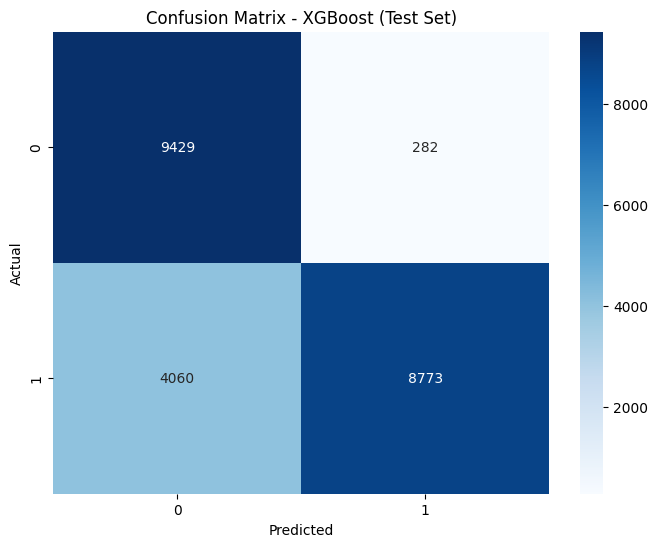


Analyzing feature importance...


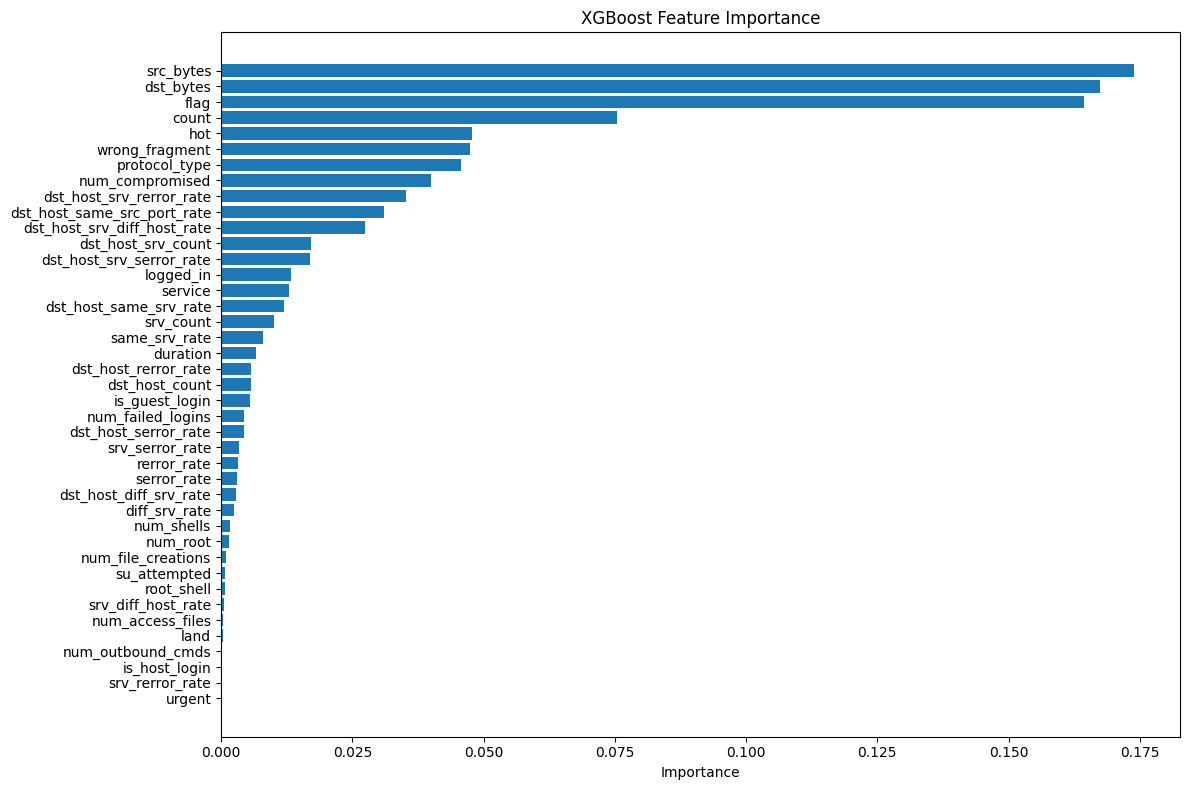


Final Results Summary:
--------------------------------------------------
Cross-validation F1 Score: 0.9987
Test Set - Accuracy: 0.8074, F1 Score: 0.8065

Best XGBoost Parameters:
  colsample_bytree: 0.8
  gamma: 0.1
  learning_rate: 0.2
  max_depth: 9
  min_child_weight: 1
  n_estimators: 25
  subsample: 1.0


In [ ]:
# Evaluate on test set
print("\nEvaluating on test set...")
y_test_pred = best_model.predict(X_test_scaled)
test_accuracy, test_f1 = evaluate_model(y_test, y_test_pred, "XGBoost (Test Set)")

# Feature importance analysis
print("\nAnalyzing feature importance...")
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train_full.columns)[sorted_idx])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Print final results
print("\nFinal Results Summary:")
print("-" * 50)
print(f"Cross-validation F1 Score: {grid_search.best_score_:.4f}")
print(f"Test Set - Accuracy: {test_accuracy:.4f}, F1 Score: {test_f1:.4f}")
print("\nBest XGBoost Parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")